In [13]:
import pandas as pd

# Load the CSV files
blurred_images_df = pd.read_csv('/kaggle/input/dataset2/dataset/celeba_blurred_images.csv')
images_df = pd.read_csv('/kaggle/input/dataset2/dataset/celeba_images.csv')

# Display the first few rows and the columns of the DataFrames
print("Blurred Images DataFrame:")
print(blurred_images_df.head())
print(blurred_images_df.columns)

print("\nReal Images DataFrame:")
print(images_df.head())
print(images_df.columns)


Blurred Images DataFrame:
   Image_ID    Filename
0         0  000038.jpg
1         1  000050.jpg
2         2  000111.jpg
3         3  000182.jpg
4         4  000280.jpg
Index(['Image_ID', 'Filename'], dtype='object')

Real Images DataFrame:
   Image_ID    Filename
0         0  000038.jpg
1         1  000050.jpg
2         2  000111.jpg
3         3  000182.jpg
4         4  000280.jpg
Index(['Image_ID', 'Filename'], dtype='object')


In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 50

class DataLoader:
    def __init__(self, blur_csv, real_csv, blur_dir, real_dir):
        self.blur_df = pd.read_csv(blur_csv)
        self.real_df = pd.read_csv(real_csv)
        self.blur_dir = blur_dir
        self.real_dir = real_dir
        
    def load_image(self, filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return tf.cast(img, tf.float32) / 255.0
    
    def create_dataset(self):
        # Create full paths
        blur_files = [os.path.join(self.blur_dir, fname) for fname in self.blur_df['Filename'].values]
        real_files = [os.path.join(self.real_dir, fname) for fname in self.real_df['Filename'].values]
        
        # Split datasets
        train_blur, temp_blur, train_real, temp_real = train_test_split(
            blur_files, real_files, test_size=0.3, random_state=42
        )
        val_blur, test_blur, val_real, test_real = train_test_split(
            temp_blur, temp_real, test_size=0.5, random_state=42
        )
        
        def create_tf_dataset(blur_files, real_files):
            blur_dataset = tf.data.Dataset.from_tensor_slices(blur_files).map(
                self.load_image, num_parallel_calls=tf.data.AUTOTUNE
            )
            real_dataset = tf.data.Dataset.from_tensor_slices(real_files).map(
                self.load_image, num_parallel_calls=tf.data.AUTOTUNE
            )
            return tf.data.Dataset.zip((blur_dataset, real_dataset))
        
        train_dataset = create_tf_dataset(train_blur, train_real).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        val_dataset = create_tf_dataset(val_blur, val_real).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_dataset = create_tf_dataset(test_blur, test_real).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        
        return train_dataset, val_dataset, test_dataset

def create_deblur_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Encoder
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    # Middle
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    
    # Decoder
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    
    # Output
    outputs = tf.keras.layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)
    
    return tf.keras.Model(inputs, outputs)


Epoch 1/50


I0000 00:00:1730434422.270153     105 service.cc:145] XLA service 0x7d6a7004e8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730434422.270230     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730434422.270238     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/219 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - loss: 0.0956 - mae: 0.2709  

I0000 00:00:1730434440.012974     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - loss: 0.0489 - mae: 0.1683 - val_loss: 0.0077 - val_mae: 0.0611
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 46s 110ms/step - loss: 0.0074 - mae: 0.0601 - val_loss: 0.0058 - val_mae: 0.0516
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.0057 - mae: 0.0516 - val_loss: 0.0046 - val_mae: 0.0447
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 0.0045 - mae: 0.0444 - val_loss: 0.0039 - val_mae: 0.0404
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 0.0040 - mae: 0.0417 - val_loss: 0.0035 - val_mae: 0.0378
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.0036 - mae: 0.0384 - val_loss: 0.0034 - val_mae: 0.0372
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 0.0034 - mae: 0.0373 - val_loss: 0.0032 - val_mae: 0.0355
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 0.0033 - mae: 0.0360 - val_loss: 0.0036 - val_mae: 0.0408
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s

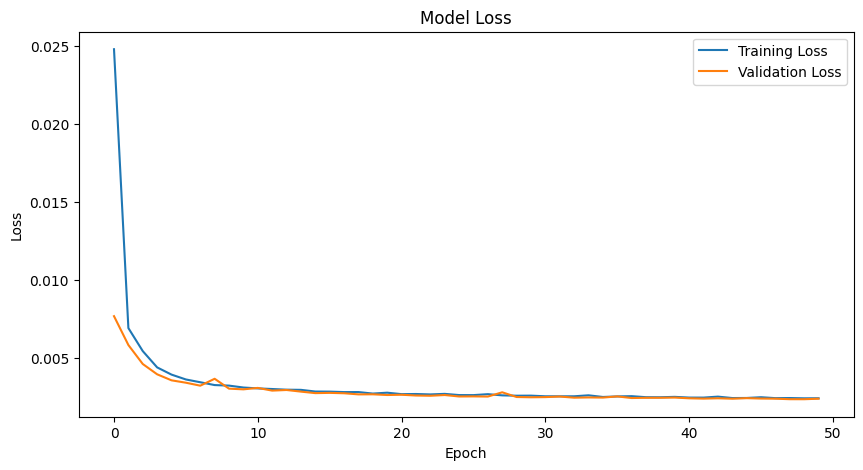

In [10]:
def train_model():
    # Initialize data loader
    data_loader = DataLoader(
        blur_csv='/kaggle/input/dataset2/dataset/celeba_blurred_images.csv',
        real_csv='/kaggle/input/dataset2/dataset/celeba_images.csv',
        blur_dir='/kaggle/input/dataset2/dataset/blur',
        real_dir='/kaggle/input/dataset2/dataset/images'
    )
    
    train_dataset, val_dataset, test_dataset = data_loader.create_dataset()
    
    # Create and compile model
    model = create_deblur_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'deblur_model_best.keras',
        monitor='val_loss',
        save_best_only=True
    )
    
    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    return model, history, test_dataset

def deblur_image(model, image_path):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)
    
    # Generate deblurred image
    deblurred = model.predict(img)
    deblurred = tf.squeeze(deblurred)
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(img))
    plt.title('Blurred Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(deblurred)
    plt.title('Deblurred Image')
    plt.axis('off')
    plt.show()
    
    return deblurred

if __name__ == "__main__":
    # Train the model
    trained_model, history, test_dataset = train_model()
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


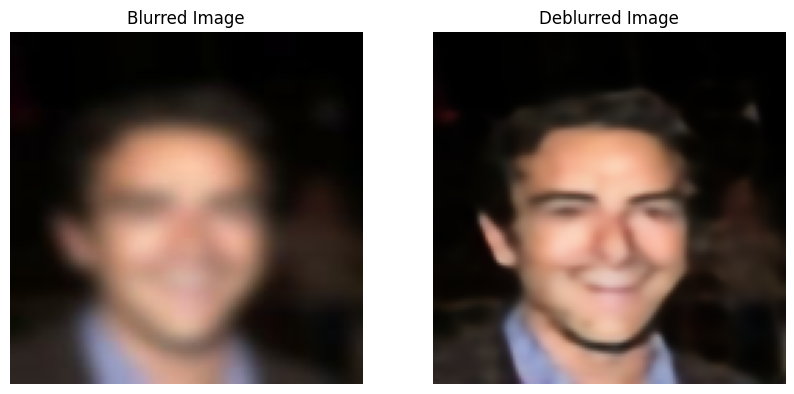

In [12]:
test_image_path = '/kaggle/input/dataset2/dataset/blur/000050.jpg'
deblurred_image = deblur_image(trained_model, test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


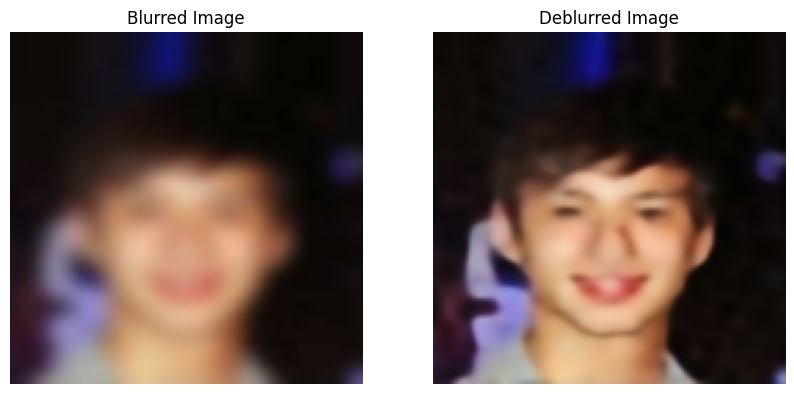

In [13]:
test_image_path = '/kaggle/input/dataset2/dataset/blur/000456.jpg'
deblurred_image = deblur_image(trained_model, test_image_path)